## load Dependancies

In [2]:
## Load packages and dependancies ##
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle

## Data Preprocessing

In [2]:
## Utility Functions ##

# obtain training data function
def create_training_data():
    
    faceCascade = cv2.CascadeClassifier('../haarcascade_face.xml')

    # Loop through training class folders
    for category in Classes:

        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category) # Class Labels

        # Loop through images in each folder
        for img in os.listdir(path):

            # Add images to training set with correct labels
            try:
                img_array = cv2.imread(os.path.join(path, img))

                # apply the necessary transformations
                img_size = 224
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_Data.append([new_array, class_num])

            except Exception as e:
                #print('Failed to Grab Image')
                pass

In [3]:
## Data Pre-Processing ##

# data Directory
Datadirectory = "Dataset/"

# Define labels
Classes = ["Person", "Not_Person"]

# Coverting to image size that is required by ImageNet (224 x 224)
img_size = 224

# Training data
training_Data = []

# Load training data
create_training_data()

# shuffle the training data
random.shuffle(training_Data)

# Convert to Array
X = [] # Features
y = [] # label

for features, label in training_Data:
    X.append(features)
    y.append(label)
    
# Convert to Numpy Array
X = np.array(X).reshape(-1, img_size, img_size, 3)
Y = np.array(y)
    
# Normalize the features
X = X/255

## Training

In [4]:
## Begin Training With The 

# Transfer Learning - Load lightweight pre-trained DL model
model = tf.keras.applications.mobilenet.MobileNet()
# model.summary()

# Obtain transfer model layer input and output
base_input = model.layers[0].input
base_ouput = model.layers[-4].output

# Modify transfer model's last layer
Flat_layer = layers.Flatten()(base_ouput)
final_output = layers.Dense(1)(Flat_layer)
# Add sigmoid since this is a binary classification
final_output = layers.Activation('sigmoid')(final_output)

# Create the revised model
new_model = keras.Model(inputs = base_input, outputs = final_output)
new_model.summary()

# Set up the model
new_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [5]:
# Fit the model to the data
epochs = 12
new_model.fit(X, Y, epochs = epochs, validation_split = 0.1)

# Save Our Model
new_model.save("../Person_With_Mask_Detection.h5")

Epoch 1/12
23/23 [==============================] - 55s 2s/step - loss: 0.2296 - accuracy: 0.8756 - val_loss: 4.0416 - val_accuracy: 0.3086
Epoch 2/12
23/23 [==============================] - 51s 2s/step - loss: 0.0698 - accuracy: 0.9848 - val_loss: 0.4288 - val_accuracy: 0.9259
Epoch 3/12
23/23 [==============================] - 49s 2s/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 1.0978e-06 - val_accuracy: 1.0000
Epoch 4/12
23/23 [==============================] - 49s 2s/step - loss: 2.0065e-04 - accuracy: 1.0000 - val_loss: 4.1775e-05 - val_accuracy: 1.0000
Epoch 5/12
23/23 [==============================] - 49s 2s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 6/12
23/23 [==============================] - 49s 2s/step - loss: 3.0199e-04 - accuracy: 1.0000 - val_loss: 1.4979e-04 - val_accuracy: 1.0000
Epoch 7/12
23/23 [==============================] - 49s 2s/step - loss: 2.8424e-05 - accuracy: 1.0000 - val_loss: 3.0585e-05 - val_accuracy:

## Testing

In [3]:
new_model = keras.models.load_model('../Person_With_Mask_Detection.h5')

In [4]:
# Function for applying transformations
def apply_image_trans(img):
    img_size = 224
    final_image = cv2.resize(img, (img_size, img_size))
    final_image = np.expand_dims(final_image, axis = 0)
    final_image = final_image/255.0
    
    return final_image

# Function for interpreting the sigmoid output
def convert_sigmoid_output(sigmoid):
    if(sigmoid < 0.50):
        print('\nThis person is Recognized!\n')
    elif(sigmoid > 0.50):
        print('\nThis person is not Recognized!\n')
    else:
        print('\nNot Sure!\n')


This person is Recognized!



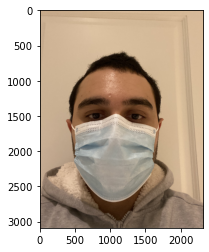

In [5]:
# Recognition test 1
frame = cv2.imread('./Dataset/Test_Images/IMG_2250.jpeg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# apply transformations to the picture 
final_image = apply_image_trans(frame)

# this is the sigmoid output
Prediction = new_model.predict(final_image)
convert_sigmoid_output(Prediction)


This person is Recognized!



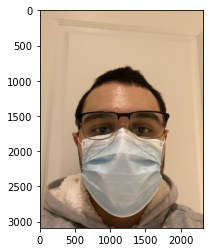

In [6]:
# Recognition test 2
frame = cv2.imread('./Dataset/Test_Images/IMG_2251.jpeg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# apply transformations to the picture 
final_image = apply_image_trans(frame)

# this is the sigmoid output
Prediction = new_model.predict(final_image)
convert_sigmoid_output(Prediction)


This person is not Recognized!



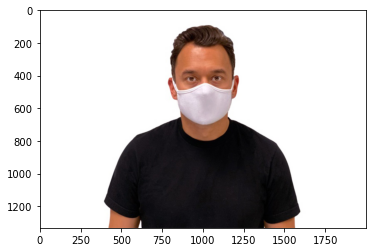

In [7]:
# Not recognized test 1
frame = cv2.imread('./Dataset/Test_Images/Not_Kaveh_1.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# apply transformations to the picture 
final_image = apply_image_trans(frame)

# this is the sigmoid output
Prediction = new_model.predict(final_image)
convert_sigmoid_output(Prediction)


This person is not Recognized!



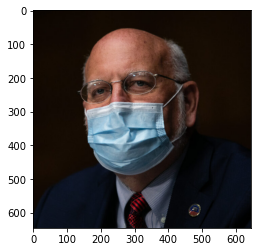

In [8]:
# Not recognized test 2
frame = cv2.imread('./Dataset/Test_Images/Not_Kaveh_2.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# apply transformations to the picture 
final_image = apply_image_trans(frame)

# this is the sigmoid output
Prediction = new_model.predict(final_image)
convert_sigmoid_output(Prediction)